In [1]:
!unzip "/content/drive/MyDrive/legal_text_classification.csv.zip"

Archive:  /content/drive/MyDrive/legal_text_classification.csv.zip
  inflating: legal_text_classification.csv  


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00


In [24]:
!pip install datasets
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=ad2fe4cd165969ca03dc375583324abd8dde11f0f36dcfb40bfe6b300ed983a0
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the original dataset
original_data = pd.read_csv('/content/legal_text_classification.csv')  # Replace 'your_dataset.csv' with your CSV file path

# Define the proportions for the train, test, and validation sets
train_ratio = 0.7  # 70% for training
test_ratio = 0.15  # 15% for testing
val_ratio = 0.15   # 15% for validation

# Split the dataset into training, testing, and validation sets
train_data, temp_data = train_test_split(original_data, test_size=(1 - train_ratio))
test_data, val_data = train_test_split(temp_data, test_size=val_ratio / (test_ratio + val_ratio))

# Save the split datasets to new CSV files
train_data.to_csv('train_dataset.csv', index=False)
test_data.to_csv('test_dataset.csv', index=False)
val_data.to_csv('validation_dataset.csv', index=False)

# Confirm the splits and save new CSV files
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Validation set size: {len(val_data)}")


Train set size: 17489
Test set size: 3748
Validation set size: 3748


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer

In [52]:
# Load the dataset
train_path = "/content/train_dataset.csv"
validation_path = "/content/validation_dataset.csv"
test_path = "/content/test_dataset.csv"

In [53]:
train_df = pd.read_csv(train_path)
validation_df = pd.read_csv(validation_path)
test_df = pd.read_csv(test_path)

In [54]:
# Display the first few rows of the dataset
print("Train Dataset - Sample Rows:")
print(train_df.head())

Train Dataset - Sample Rows:
     case_id case_outcome                                         case_title  \
0  Case11607   considered  Trade Practices Commission v David Jones (Aust...   
1    Case536      applied  John Pfeiffer Pty Limited v Rogerson [2000] HC...   
2   Case3769  referred to  Australian Competition &amp; Consumer Commissi...   
3   Case1253  referred to                    Mercado v Holmes [2000] FCA 620   
4   Case8278     followed  NADR v Minister for Immigration and Multicultu...   

                                           case_text  
0  The authorities on s 45 of the TPA explain the...  
1  governing law with respect to torts committed ...  
2  the present circumstances, the unconscionable ...  
3  The majority in Yung (Burchett and Hill JJ) di...  
4  The appellant's notice of appeal raises four g...  


In [55]:
# Summary statistics
print("Train Dataset - Summary Statistics:")
print(train_df.describe())

Train Dataset - Summary Statistics:
          case_id case_outcome  \
count       17489        17489   
unique      17489           10   
top     Case11607        cited   
freq            1         8583   

                                               case_title  \
count                                               17489   
unique                                              13762   
top     Minister for Immigration and Ethnic Affairs v ...   
freq                                                   44   

                                                case_text  
count                                               17355  
unique                                              13448  
top     submitted that this Court should hold that the...  
freq                                                   28  


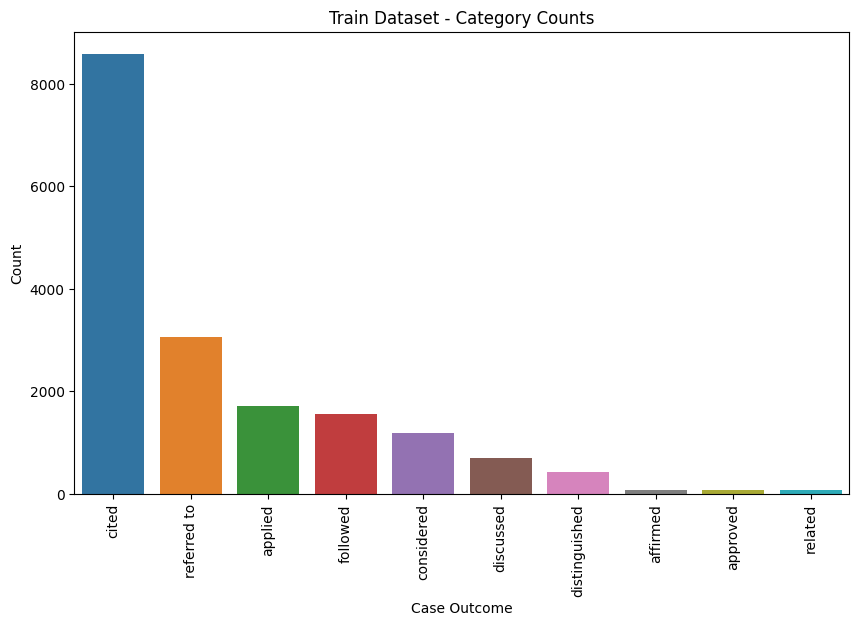

In [59]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(data=train_df, x='case_outcome', order=category_counts.index)

# Customize the plot
plt.title("Train Dataset - Category Counts")
plt.xlabel("Case Outcome")
plt.ylabel("Count")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

In [58]:
category_counts = train_df['case_outcome'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Train Dataset - Category Counts:
cited            8583
referred to      3066
applied          1723
followed         1567
considered       1195
discussed         693
distinguished     438
affirmed           78
approved           74
related            72
Name: case_outcome, dtype: int64


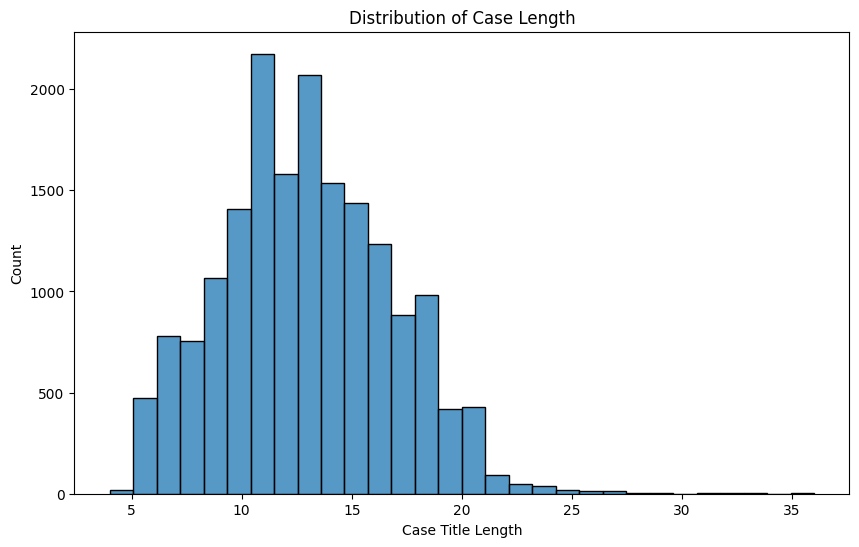

In [60]:
# Distribution of article length
train_df['case_title_len'] = train_df['case_title'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='case_title_len', bins=30)
plt.title("Distribution of Case Length")
plt.xlabel("Case Title Length")
plt.show()

In [61]:
# Balancing Check
category_counts = train_df['case_title'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Train Dataset - Category Counts:
Minister for Immigration and Ethnic Affairs v Wu Shan Liang [1996] HCA 6 ; (1996) 185 CLR 259                                44
Minister for Aboriginal Affairs v Peko-Wallsend Ltd [1986] HCA 40 ; (1986) 162 CLR 24                                        28
General Steel Industries Inc v Commissioner for Railways (NSW) [1964] HCA 69 ; (1964) 112 CLR 125                            28
Minister for Immigration and Multicultural Affairs v Yusuf [2001] HCA 30 ; (2001) 206 CLR 323                                27
SAAP v Minister for Immigration and Multicultural and Indigenous Affairs [2005] HCA 24 ; (2005) 215 ALR 162                  26
                                                                                                                             ..
Re Soci&eacute;t&eacute; Schneider Electric (2002) 4 ITLR 1077                                                                1
Allphones Retail Pty Ltd v Hoy Mobile Pty Ltd [2009] FCAFC 85          

In [84]:
#  Data Cleaning and Preprocessing (text-based EDA)
# Remove any non-alphanumeric characters and extra whitespaces
import re

def clean_text(text):
    if isinstance(text, str):
        # If the input is a string, perform cleaning
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(' +', ' ', text)
    return text

# Apply the modified clean_text function to the columns
train_df['case_text'] = train_df['case_text'].apply(clean_text)
train_df['case_title'] = train_df['case_title'].apply(clean_text)


In [85]:
# Check for missing data
missing_data = train_df.isnull().sum()
print("Missing Data:")
print(missing_data)

# Handle missing data if necessary

# Explore other aspects of the data (e.g., word frequency, text sentiment, etc.) as needed for your task.

# Balancing Check (if relevant)
# Check if there is an imbalance in the target variable (e.g., if you have categories)
category_counts = train_df['case_title_len'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Missing Data:
case_id             0
case_outcome        0
case_title          0
case_text         134
case_title_len      0
dtype: int64
Train Dataset - Category Counts:
11    2175
13    2068
12    1579
14    1535
15    1438
10    1405
16    1235
9     1067
18     982
17     884
7      778
8      753
6      474
19     420
20     287
21     142
22      95
23      49
24      36
25      20
5       17
26      15
27      12
29       6
28       5
31       3
32       2
33       2
4        1
36       1
30       1
34       1
35       1
Name: case_title_len, dtype: int64


In [88]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_metric
from rouge_score import rouge_scorer

In [89]:
model_name = "facebook/bart-large-cnn"

# Load the BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

In [90]:
# Function to generate summaries
def generate_summary(article_text):
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=100, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    rouge = load_metric("rouge")
    scores = rouge.compute(predictions=[generated_summary], references=[original_summary])
    return scores

In [91]:
# Summarize and evaluate a single article from the test dataset
case_data = test_df.iloc[0]['case_text']
original_summary = test_df.iloc[0]['case_title']
generated_summary = generate_summary(case_data)
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

print("Original Summary:")
print(original_summary)
print("\nGenerated Summary:")
print(generated_summary)

Original Summary:
Singh v Minister for Immigration and Ethnic Affairs [1994] FCA 1011

Generated Summary:
The Tribunal found that it was required to be satisfied "to a high degree" that the information upon which the visa cancellation was based was correct. The Tribunal referred to the decisions of Quan v Minister for Immigration and Multicultural &amp; Indigenous Affairs [2004] FCA 764.


In [92]:
# Calculate ROUGE scores
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
rouge_scores = rouge_scorer.score(generated_summary, original_summary)

# Print ROUGE scores line by line
for metric, scores in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {scores.precision}")
    print(f"Recall: {scores.recall}")
    print(f"F1 Score: {scores.fmeasure}")
    print()

rouge1:
Precision: 0.6363636363636364
Recall: 0.15217391304347827
F1 Score: 0.2456140350877193

rouge2:
Precision: 0.4
Recall: 0.08888888888888889
F1 Score: 0.14545454545454545

rougeL:
Precision: 0.6363636363636364
Recall: 0.15217391304347827
F1 Score: 0.2456140350877193

rougeLsum:
Precision: 0.6363636363636364
Recall: 0.15217391304347827
F1 Score: 0.2456140350877193



In [93]:
# Function to calculate word overlap accuracy
def calculate_accuracy(original_summary, generated_summary):
    # Split summaries into words
    original_words = set(original_summary.split())
    generated_words = set(generated_summary.split())

    # Calculate the intersection of words (common words)
    common_words = original_words.intersection(generated_words)

    # Calculate accuracy as the ratio of common words to total words in the original summary
    accuracy = len(common_words) / len(original_words) if len(original_words) > 0 else 0.0
    return accuracy

# Calculate and print accuracy
accuracy = calculate_accuracy(original_summary, generated_summary)
print(f"Word Overlap Accuracy: {accuracy:.2%}")

Word Overlap Accuracy: 63.64%


In [94]:
# Calculate and print the average ROUGE F1 score
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.2206


In [95]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
# Function to generate summaries using T5
def generate_summary(article_text):
    input_text = "summarize: " + article_text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    summary_ids = model.generate(input_ids, max_length=100, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    rouge = load_metric("rouge")
    scores = rouge.compute(predictions=[generated_summary], references=[original_summary])
    return scores

# Function to calculate word overlap accuracy
def calculate_accuracy(original_summary, generated_summary):
    original_words = set(original_summary.split())
    generated_words = set(generated_summary.split())
    common_words = original_words.intersection(generated_words)
    accuracy = len(common_words) / len(original_words) if len(original_words) > 0 else 0.0
    return accuracy

# Evaluate the model on a sample article
sample_index = 0  # Change this to evaluate other articles
case_data = test_df.iloc[sample_index]['case_text']
original_summary = test_df.iloc[sample_index]['case_title']
generated_summary = generate_summary(case_data)

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

# Calculate word overlap accuracy
accuracy = calculate_accuracy(original_summary, generated_summary)

# Print the results
print("Original Summary:")
print(original_summary)
print("\nGenerated Summary:")
print(generated_summary)

Original Summary:
Singh v Minister for Immigration and Ethnic Affairs [1994] FCA 1011

Generated Summary:
The Tribunal found that it was required to be satisfied "to a high degree" that the information upon which the visa cancellation was based was correct. The Tribunal referred to the decisions of Quan v Minister for Immigration and Multicultural &amp; Indigenous Affairs [2004] FCA 764 at [33] - [34] per Jacobson J.


In [96]:
# Calculate ROUGE scores
from rouge_score import rouge_scorer

# Define ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])

# Calculate ROUGE scores
rouge_scores = scorer.score(generated_summary, original_summary)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {scores.precision:.4f}")
    print(f"Recall: {scores.recall:.4f}")
    print(f"F1 Score: {scores.fmeasure:.4f}")
    print()

rouge1:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222

rouge2:
Precision: 0.4000
Recall: 0.0784
F1 Score: 0.1311

rougeL:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222

rougeLsum:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222



In [97]:
print(f"Word Overlap Accuracy: {accuracy:.2%}")

Word Overlap Accuracy: 63.64%


In [98]:
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.1995


In [99]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_metric
from rouge_score import rouge_scorer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
# Function to generate summaries using DistilBERT
def generate_summary(article_text, max_length=100):
    # Tokenize and generate the summary
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate word overlap accuracy
def calculate_accuracy(original_summary, generated_summary):
    original_words = set(original_summary.split())
    generated_words = set(generated_summary.split())
    common_words = original_words.intersection(generated_words)
    accuracy = len(common_words) / len(original_words) if len(original_words) > 0 else 0.0
    return accuracy

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    # Import the necessary library
    from rouge_score import rouge_scorer

    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])

    # Calculate ROUGE scores
    rouge_scores = scorer.score(generated_summary, original_summary)
    return rouge_scores

In [101]:
# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

# Print the ROUGE scores
for metric, score in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {score.precision:.4f}")
    print(f"Recall: {score.recall:.4f}")
    print(f"F1 Score: {score.fmeasure:.4f}")
    print()

rouge1:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222

rouge2:
Precision: 0.4000
Recall: 0.0784
F1 Score: 0.1311

rougeL:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222

rougeLsum:
Precision: 0.6364
Recall: 0.1346
F1 Score: 0.2222



In [102]:
accuracy = calculate_accuracy(original_summary, generated_summary)
print(f"Word Overlap Accuracy: {accuracy:.2%}")

Word Overlap Accuracy: 63.64%


In [103]:
# Calculate and print the average ROUGE F1 score
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.1995
